# Working with Occupancy Grids

While isoext is designed for signed distance fields (SDFs), you can also extract surfaces from **binary occupancy grids**—voxel grids where each cell is either occupied (1) or empty (0).

This is useful when:
- You have voxelized data from 3D scanning or segmentation
- Your data comes from a boolean CSG operation
- You want to convert a mesh to voxels and back


In [1]:
import torch
import isoext
from isoext.sdf import SphereSDF
from _viz import show_mesh


Running cmake --build & --install in /home/gcnick/Documents/code/isoext/build/cp312-abi3-linux_x86_64


## Creating an Occupancy Grid

Let's create a binary occupancy grid from a sphere SDF. Values > 0 are outside, so we threshold to get a binary mask:


In [2]:
# Create a grid and compute sphere SDF
grid = isoext.UniformGrid([64, 64, 64])
sdf_values = SphereSDF(radius=0.7)(grid.get_points())

# Convert to binary occupancy: 0 = outside, 1 = inside
occupancy = (sdf_values < 0.0).float()

print(f"Occupancy values: {occupancy.unique().tolist()}")


Occupancy values: [0.0, 1.0]


## Direct Extraction (Jagged Result)

You can run marching cubes directly on the binary grid using `level=0.5` (the boundary between 0 and 1). However, the result will be **jagged** because there's no gradient information—every surface point lands exactly on a voxel face:


Jagged mesh: 9168 vertices, 18332 faces


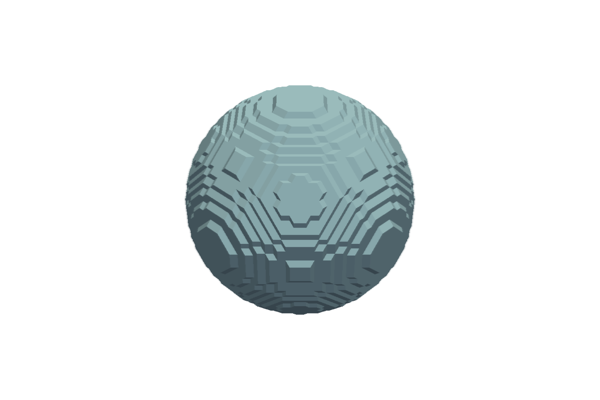

In [3]:
grid.set_values(occupancy)
v_jagged, f_jagged = isoext.marching_cubes(grid, level=0.5)

print(f"Jagged mesh: {v_jagged.shape[0]} vertices, {f_jagged.shape[0]} faces")
show_mesh(v_jagged, f_jagged, smooth_shading=False)


## Smoothed Extraction

To get a smoother result, apply **Gaussian smoothing** before extraction. This blurs the sharp 0/1 transitions into gradual gradients, allowing marching cubes to interpolate vertex positions:


Smooth mesh: 8232 vertices, 16460 faces


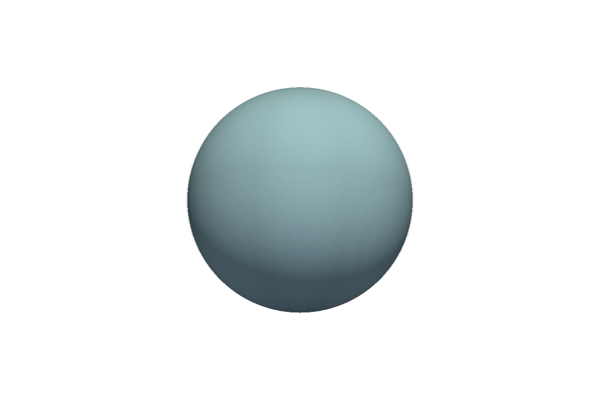

In [4]:
# Smooth the occupancy grid
smoothed = isoext.gaussian_smooth(occupancy, sigma=5.0)
grid.set_values(smoothed)
v_smooth, f_smooth = isoext.marching_cubes(grid, level=0.5)

print(f"Smooth mesh: {v_smooth.shape[0]} vertices, {f_smooth.shape[0]} faces")
show_mesh(v_smooth, f_smooth)
